In [47]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from keras.models import Sequential, load_model
from keras.layers import Embedding, Flatten, Dense, LSTM, Dropout
from keras import optimizers

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [2]:
dir = 'C:/Users/gustav.k.lundberg/python_devenv/workspace/text_analysis/dataset/imdb/aclImdb/aclImdb/test'
x = []
y = []
for label in ['pos', 'neg']:
    for fname in os.listdir(dir + '/'+ label):
        f = open(dir + '/'+ label + '/' + fname, encoding="utf8")
        x.append(f.read())
        y.append(label)

y = [0 if label=='neg' else 1 for label in y]

In [3]:
print('x = ', len(x), type(x[0]), x[0])
print('y = ', len(y), y[0])

x =  17243 <class 'str'> I went and saw this movie last night after being coaxed to by a few friends of mine. I'll admit that I was reluctant to see it because from what I knew of Ashton Kutcher he was only able to do comedy. I was wrong. Kutcher played the character of Jake Fischer very well, and Kevin Costner played Ben Randall with such professionalism. The sign of a good movie is that it can toy with our emotions. This one did exactly that. The entire theater (which was sold out) was overcome by laughter during the first half of the movie, and were moved to tears during the second half. While exiting the theater I not only saw many women in tears, but many full grown men as well, trying desperately not to let anyone see them crying. This movie was great, and I suggest that you go see it before you judge.
y =  17243 1


In [4]:
### Tokenize the data ### 
maxlen = 100 # Use only the first maxlen words in each review
num_training_samples = 5000
#num_validation_samples = 10000
max_words = 10000

tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(x)
sequences = tokenizer.texts_to_sequences(x)
word_index = tokenizer.word_index

x_data = pad_sequences(sequences = sequences, maxlen = maxlen, padding = 'post', truncating = 'post')

x_train, x_test, y_train, y_test = train_test_split(x_data, y, train_size = num_training_samples)

In [5]:
# Only keep the top max_word entries of the dictionary
word_index = {key: item for key, item in word_index.items() if item < max_words}
#print(len(word_index))

In [6]:
#print(type(sequences))
#print(len(sequences))
#print(sequences[0])

#print(type(word_index))
#print(len(word_index))
#print(word_index)

#print(type(data))
#print(data.shape)
#print(data[0])

#print(type(x_train))
#print(x_train.shape)
#print(x_train[0])

#print(type(x_test))
#print(x_test.shape)
#print(x_test[0])

#print(type(y_train))
#print(len(y_train))
#print(y_train[0])

#print(type(y_test))
#print(len(y_test))
#print(y_test[0])

In [7]:
### Loading the pre-trained embedding GloVe ###
dir = 'C:/Users/gustav.k.lundberg/python_devenv/workspace/text_analysis/embeddings/glove.6B/glove.6B.100d.txt'

with open(dir, 'r', encoding="utf8") as f:
    embedding = f.readlines()

word_coefs_dict = {}
i = 0

for line in embedding:
    lst = line.split()
    word_coefs_dict[lst[0]] = lst[1:]
    if i == 0:
        embed_dim = len(lst[1:])
#    words.append(lst[0])
#    coefs.append(lst[1:])



In [8]:
### Buidling the embedded matrix from the Glove embedding ###

# word_index - word, word_index
# word_coefs_dict - word, coefs

embedding_mat = np.zeros((max_words, embed_dim))
print(embedding_mat.shape)

i = 0
for word, index in word_index.items():

    try:
        embedding_mat[index] = word_coefs_dict[word]
    except:
        print('Word not in GloVe embedding = ', word)

print(type(embedding_mat), embedding_mat.shape)

(10000, 100)
Word not in GloVe embedding =  it's
Word not in GloVe embedding =  don't
Word not in GloVe embedding =  i'm
Word not in GloVe embedding =  didn't
Word not in GloVe embedding =  doesn't
Word not in GloVe embedding =  can't
Word not in GloVe embedding =  that's
Word not in GloVe embedding =  isn't
Word not in GloVe embedding =  there's
Word not in GloVe embedding =  i've
Word not in GloVe embedding =  he's
Word not in GloVe embedding =  wasn't
Word not in GloVe embedding =  you're
Word not in GloVe embedding =  couldn't
Word not in GloVe embedding =  she's
Word not in GloVe embedding =  they're
Word not in GloVe embedding =  i'd
Word not in GloVe embedding =  you'll
Word not in GloVe embedding =  won't
Word not in GloVe embedding =  wouldn't
Word not in GloVe embedding =  
Word not in GloVe embedding =  i'll
Word not in GloVe embedding =  aren't
Word not in GloVe embedding =  film's
Word not in GloVe embedding =  what's
Word not in GloVe embedding =  haven't
Word not in Glo

In [9]:
### Building a non-RNN model, freezing the pretrained weights ###
model_naive = Sequential()
model_naive.add(Embedding(input_dim = max_words, output_dim = embed_dim, input_length = maxlen))
model_naive.add(Flatten())
model_naive.add(Dense(32, activation = 'relu'))
model_naive.add(Dense(1, activation = 'sigmoid'))

# Add the pretrained embeddings (GloVe), i.e. the matrix embedding_mat into the embedded layer in the model
#print(model_naive.layers[0].get_weights())
model_naive.layers[0].set_weights([embedding_mat])
#print(model_naive.layers[0].get_weights())
model_naive.layers[0].trainable = False # Potentially freeze the weights of the embedded layer if you don't want to train it
model_naive.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 320,065
Non-trainable params: 1,000,000
_________________________________________________________________


In [10]:
### Training the model ###
learning_rate = 0.001
batch_size = 32
num_epochs = 10

opt = optimizers.RMSprop(learning_rate = learning_rate, rho = 0.9)
model_naive.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['acc'])

history_naive = model_naive.fit(x = x_train,
                    y = y_train,
                    epochs = num_epochs,
                    batch_size = batch_size, 
                    validation_data = (x_test, y_test))

# Saving the weights
model_naive.save_weights('C:/Users/gustav.k.lundberg/python_devenv/workspace/text_analysis/models/imdb_model_naive.h5')

Instructions for updating:
Use tf.cast instead.
Train on 5000 samples, validate on 12243 samples
Epoch 1/10
5000/5000 [==============================] - 3s 553us/step - loss: 0.7001 - acc: 0.6872 - val_loss: 0.9494 - val_acc: 0.3854
Epoch 2/10
5000/5000 [==============================] - 3s 540us/step - loss: 0.4998 - acc: 0.7678 - val_loss: 1.5945 - val_acc: 0.3012
Epoch 3/10
5000/5000 [==============================] - 3s 534us/step - loss: 0.4461 - acc: 0.7990 - val_loss: 0.6136 - val_acc: 0.6779
Epoch 4/10
5000/5000 [==============================] - 2s 491us/step - loss: 0.3576 - acc: 0.8440 - val_loss: 0.8623 - val_acc: 0.7313
Epoch 5/10
5000/5000 [==============================] - 2s 465us/step - loss: 0.2914 - acc: 0.8792 - val_loss: 0.6584 - val_acc: 0.6875
Epoch 6/10
5000/5000 [==============================] - 2s 494us/step - loss: 0.2421 - acc: 0.8966 - val_loss: 0.7594 - val_acc: 0.7426
Epoch 7/10
5000/5000 [==============================] - 3s 539us/step - loss: 0.1975 - 

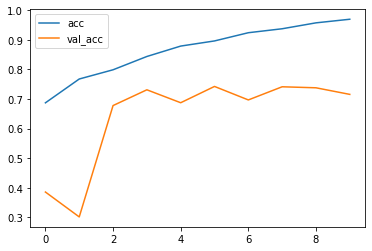

In [11]:
### Plotting the accuracy ###
epochs = range(num_epochs)
plt.plot(epochs, history_naive.history['acc'])
plt.plot(epochs, history_naive.history['val_acc'])
plt.legend(['acc', 'val_acc'])

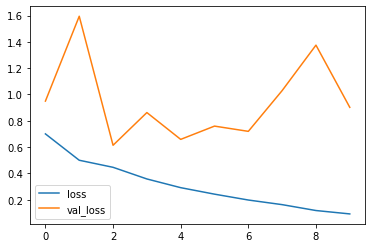

In [12]:
### Plotting the losses ###
epochs = range(num_epochs)
plt.plot(epochs, history_naive.history['loss'])
plt.plot(epochs, history_naive.history['val_loss'])
plt.legend(['loss', 'val_loss'])

<h2>RNN models</h2>

In [53]:
### Building a non-RNN model, freezing the pretrained weights ###
model_RNN = Sequential()
model_RNN.add(Embedding(input_dim = max_words, output_dim = embed_dim, input_length = maxlen))
model_RNN.add(Dropout(rate = 0.5))
model_RNN.add(LSTM(32, activation = 'relu', return_sequences = True))
model_RNN.add(Dropout(rate = 0.5))
model_RNN.add(LSTM(8, activation = 'relu', return_sequences = False))
model_RNN.add(Dense(1, activation = 'sigmoid'))

# Add the pretrained embeddings (GloVe), i.e. the matrix embedding_mat into the embedded layer in the model
#print(model_naive.layers[0].get_weights())
model_RNN.layers[0].set_weights([embedding_mat])
#print(model_naive.layers[0].get_weights())
model_RNN.layers[0].trainable = True # Potentially freeze the weights of the embedded layer if you don't want to train it
model_RNN.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
dropout_6 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 100, 32)           17024     
_________________________________________________________________
dropout_7 (Dropout)          (None, 100, 32)           0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 8)                 1312      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 1,018,345
Trainable params: 1,018,345
Non-trainable params: 0
____________________________________________

In [54]:
### Hyperparameters ###
learning_rate = 0.001
batch_size = 128
num_epochs = 50

In [55]:
### Compiling the model ###
opt = optimizers.RMSprop(learning_rate = learning_rate, rho = 0.9, decay = 1e-5)
model_RNN.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['acc'])

In [56]:
### Loading a model ###
#model_RNN_loaded = Sequential()
#model_RNN_loaded = load_model('C:/Users/gustav.k.lundberg/python_devenv/workspace/text_analysis/models/imdb_model_RNN.h5')
#model_RNN.summary()

In [57]:
history_RNN = model_RNN.fit(x = x_train,
                    y = y_train,
                    epochs = num_epochs,
                    batch_size = batch_size, 
                    validation_data = (x_test, y_test))

# Saving the weights
model_RNN.save_weights('C:/Users/gustav.k.lundberg/python_devenv/workspace/text_analysis/models/imdb_model_RNN.h5')

Train on 5000 samples, validate on 12243 samples
Epoch 1/50
5000/5000 [==============================] - 15s 3ms/step - loss: 0.5988 - acc: 0.7260 - val_loss: 0.5873 - val_acc: 0.7228
Epoch 2/50
5000/5000 [==============================] - 13s 3ms/step - loss: 0.5783 - acc: 0.7302 - val_loss: 0.5913 - val_acc: 0.7228
Epoch 3/50
5000/5000 [==============================] - 14s 3ms/step - loss: 0.5787 - acc: 0.7296 - val_loss: 0.6304 - val_acc: 0.7228
Epoch 4/50
5000/5000 [==============================] - 13s 3ms/step - loss: 0.6003 - acc: 0.7302 - val_loss: 0.5649 - val_acc: 0.7228
Epoch 5/50
5000/5000 [==============================] - 13s 3ms/step - loss: 0.5588 - acc: 0.7304 - val_loss: 0.6023 - val_acc: 0.7228
Epoch 6/50
5000/5000 [==============================] - 12s 2ms/step - loss: 0.5609 - acc: 0.7308 - val_loss: 0.6063 - val_acc: 0.7228
Epoch 7/50
5000/5000 [==============================] - 13s 3ms/step - loss: 0.5428 - acc: 0.7302 - val_loss: 0.5285 - val_acc: 0.7238
Epoch 

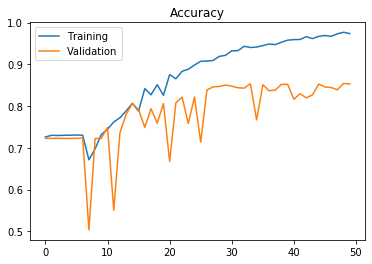

In [58]:
### Plotting the accuracy ###
epochs = range(num_epochs)
plt.plot(epochs, history_RNN.history['acc'])
plt.plot(epochs, history_RNN.history['val_acc'])
plt.title('Accuracy')
plt.legend(['Training', 'Validation'])

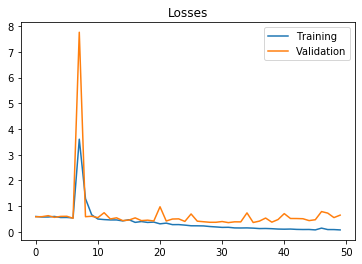

In [59]:
### Plotting the losses ###
epochs = range(num_epochs)
plt.plot(epochs, history_RNN.history['loss'])
plt.plot(epochs, history_RNN.history['val_loss'])
plt.title('Losses')
plt.legend(['Training', 'Validation'])